In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

# EXERCISE 2

In [2]:
A = 8.8480182

In [3]:

def f_vectorized(x, A):
    x = np.asarray(x)
    # Only compute for -3 <= x <= 3, else 0
    return np.where((x >= -3) & (x <= 3), (1/A) * (x**2) * (np.sin(np.pi * x))**2, 0)

def g_vectorized(x):
    x = np.asarray(x)
    return np.where((x >= -3) & (x <= 3), (x**2)/18, 0)

def cg_vectorized(x, A):
    x = np.asarray(x)
    return np.where((x >= -3) & (x <= 3), (x**2)/A, 0)

def g_inv_vectorized(u):
    u = np.asarray(u)
    # Using np.sqrt ensures the square root is computed correctly for negative numbers.
    return np.where((u >= 0) & (u <= 1), 3*np.cbrt(2*(u-(1/2))), 0)

def cg_inv_vectorized(u, A):
    u = np.asarray(u)
    # Using np.cbrt ensures the cube root is computed correctly for negative numbers.
    return np.where((u >= 0) & (u <= 1), np.cbrt(3*A*u - 27), 0)



In [4]:
# rejection sampling
NUM_SAMPLES = int(1e7)

def run_rejection_sampling(num_samples=NUM_SAMPLES):
    # Sample X from proposal g(x) using its inverse CDF
    U1 = np.random.uniform(0, 1, num_samples)
    X = g_inv_vectorized(U1)  # X ~ g(x)

    a = f_vectorized(X, A)
    b = cg_vectorized(X, A)  # scaled cg(x)
    # Sample uniform U2 ~ Uniform[0, cg(X)]
    U2 = np.random.uniform(0, b, num_samples)

    rej_vec = np.where(U2 < a, 1, 0)  # 1 if accepted, 0 if rejected
    acc_count = np.sum(rej_vec)


    return X, rej_vec, acc_count


In [5]:
def sample_valid(n_valid, batch_size):
    """
    Returns an array of n_valid accepted samples using run_rejection_sampling.
    batch_size specifies the number of points to generate in each rejection sampling run.
    """
    accepted_samples = []
    
    while len(accepted_samples) < n_valid:
        X, rej_vec, _ = run_rejection_sampling(num_samples=batch_size)
        # Select accepted samples
        valid_samples = X[rej_vec == 1]
        # Append them to our running list
        accepted_samples.extend(valid_samples.tolist())
        
    # Return exactly n_valid accepted samples as a numpy array
    return np.array(accepted_samples[:n_valid])

Acceptance count: 4913920
Acceptance rate: 0.491392


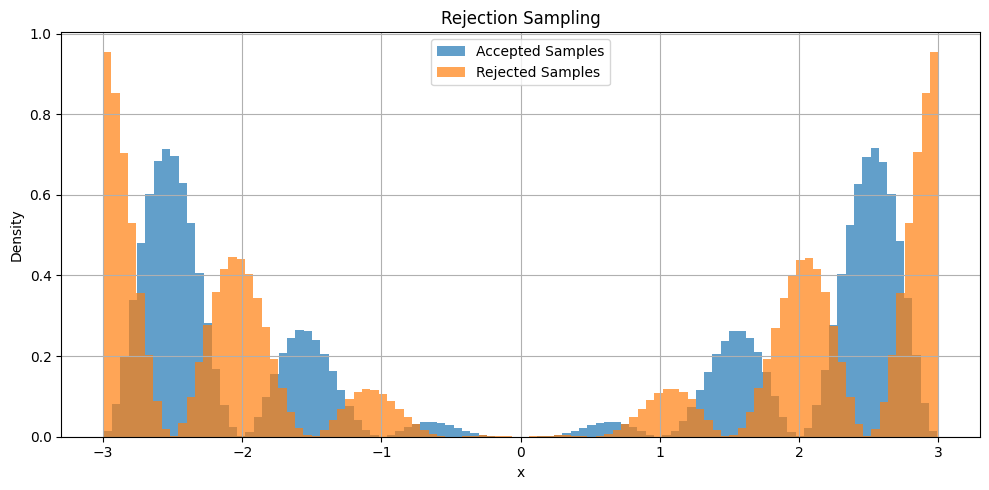

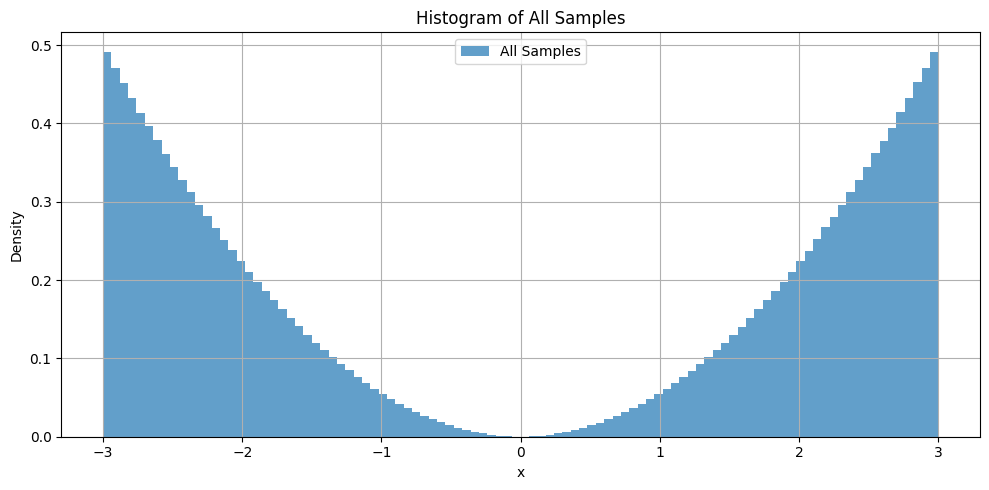

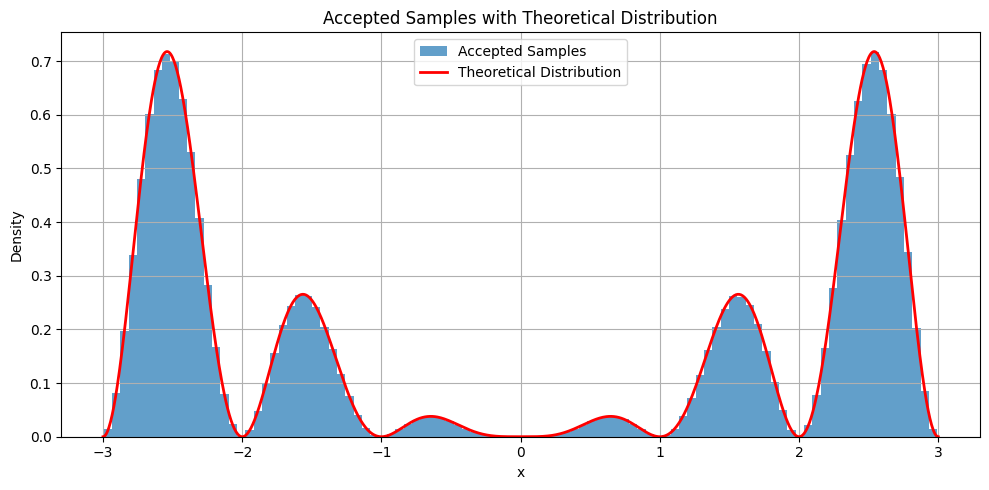

In [6]:
x_vals = np.linspace(-3, 3, 1000)
y_vals = f_vectorized(x_vals, A)

X, rej_vec, acc_count = run_rejection_sampling(NUM_SAMPLES)

print("Acceptance count:", acc_count)
print("Acceptance rate:", acc_count / NUM_SAMPLES)
    
plt.figure(figsize=(10, 5))
plt.hist(X[rej_vec == 1], bins=100, density=True, alpha=0.7, label='Accepted Samples')
plt.hist(X[rej_vec == 0], bins=100, density=True, alpha=0.7, label='Rejected Samples')
plt.title("Rejection Sampling")
plt.xlabel("x")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# Plotting the histogram of all samples
plt.figure(figsize=(10, 5))
plt.hist(X, bins=100, density=True, alpha=0.7, label='All Samples')
plt.title("Histogram of All Samples")
plt.xlabel("x")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# Plotting the histogram of accepted samples with the theoretical distribution
plt.figure(figsize=(10, 5))
plt.hist(X[rej_vec == 1], bins=100, density=True, alpha=0.7, label='Accepted Samples')
plt.plot(x_vals, y_vals, label='Theoretical Distribution', color='red', linewidth=2)
plt.title("Accepted Samples with Theoretical Distribution")
plt.xlabel("x")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



Median: -1.2406785374227791
Confidence Interval: (-1.6564148112969277, 1.4511753692967477)
Confidence Interval width: 3.107590180593675
0.9 Quantile: 2.63867301655598
Confidence Interval: (2.5748010042193847, 2.7510830452216313)
Confidence Interval width: 0.17628204100224654
Mean: -0.08711874623036739
Confidence Interval: (-0.4063237408414726, 0.23208624838073785)
Confidence Interval width: 0.6384099892222105


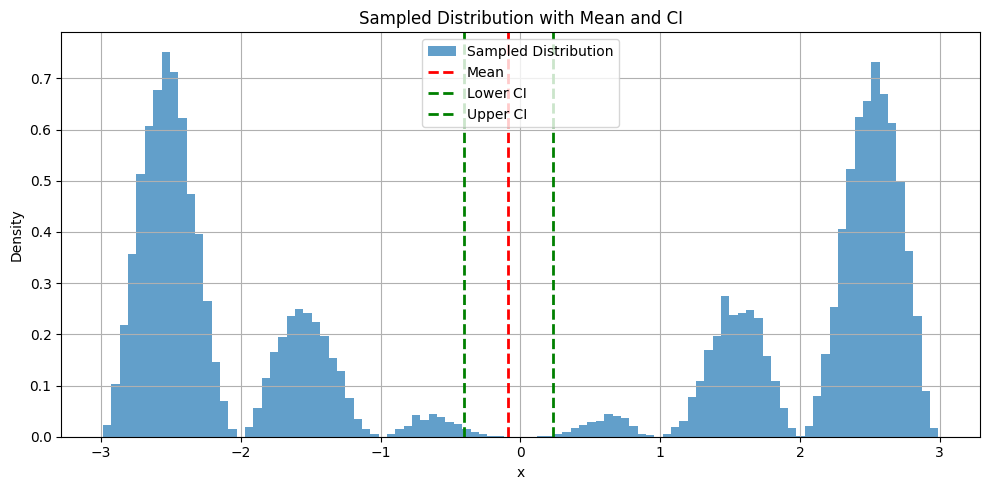

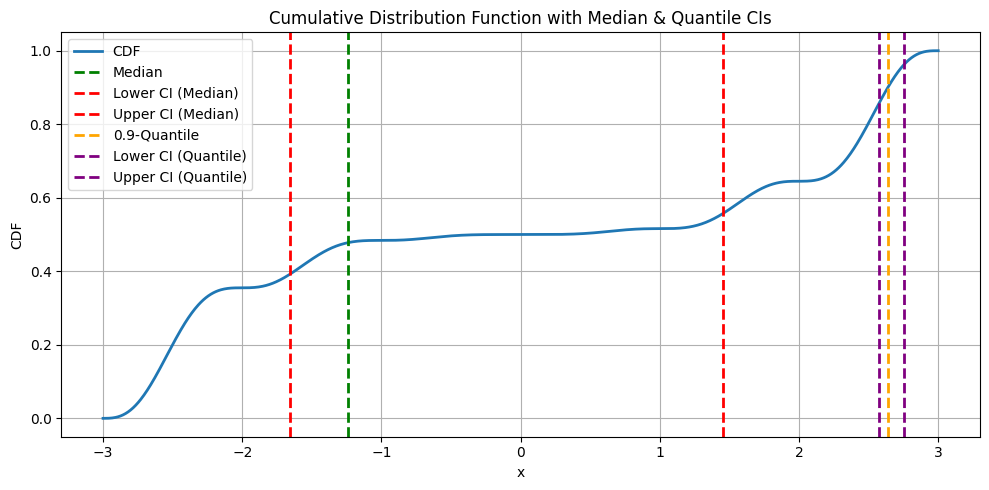

In [7]:
num_samples = 20000
sample = sample_valid(n_valid=num_samples, batch_size=1000)

num_subsamples = 200
subsample = sample[:num_subsamples] # Take the first 200 samples

ordered_subsample = np.sort(subsample)

# Median
median = np.median(ordered_subsample)
l_idx_CI = math.floor((0.5*num_subsamples)-(0.98*math.sqrt(num_subsamples)))
u_idx_CI = math.ceil((0.5*num_subsamples)+1+(0.98*math.sqrt(num_subsamples)))

l_CI = ordered_subsample[l_idx_CI]
u_CI = ordered_subsample[u_idx_CI]


# 0.9 quantile 

q = 0.9
quantile = np.quantile(ordered_subsample, q)
l_idx_q = math.floor((q * num_subsamples) - (0.98 * math.sqrt(num_subsamples)))
u_idx_q = math.ceil((q * num_subsamples) + 1 + (0.98 * math.sqrt(num_subsamples)))

l_CI_q = ordered_subsample[l_idx_q]
u_CI_q = ordered_subsample[u_idx_q]


# Mean
sample_std_dev = np.std(subsample, ddof=1) # Sample standard deviation with Bessel's correction
sample_mean = np.mean(subsample)
l_CI_mean = sample_mean - 1.96*sample_std_dev/math.sqrt(num_subsamples)
u_CI_mean = sample_mean + 1.96*sample_std_dev/math.sqrt(num_subsamples)



print("Median:", median)
print("Confidence Interval:", (float(l_CI), float(u_CI)))
print("Confidence Interval width:", float(u_CI) - float(l_CI))
print("=================================================================")
print("0.9 Quantile:", quantile)
print("Confidence Interval:", (float(l_CI_q), float(u_CI_q)))
print("Confidence Interval width:", float(u_CI_q) - float(l_CI_q))
print("=================================================================")
print("Mean:", sample_mean)
print("Confidence Interval:", (float(l_CI_mean), float(u_CI_mean)))
print("Confidence Interval width:", float(u_CI_mean) - float(l_CI_mean))




plt.figure(figsize=(10, 5))
plt.hist(sample, bins=100, density=True, alpha=0.7, label='Sampled Distribution')
plt.axvline(sample_mean, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(l_CI_mean, color='green', linestyle='dashed', linewidth=2, label='Lower CI')
plt.axvline(u_CI_mean, color='green', linestyle='dashed', linewidth=2, label='Upper CI')
plt.title("Sampled Distribution with Mean and CI")
plt.xlabel("x")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Create x-values matching the density array and compute the CDF.
x_points = np.linspace(-3, 3, len(y_vals))
dx = x_points[1] - x_points[0]
cdf = np.cumsum(y_vals) * dx

plt.figure(figsize=(10, 5))
plt.plot(x_points, cdf, linewidth=2, label="CDF")

# Add median and its confidence intervals.
plt.axvline(median, color='green', linestyle='dashed', linewidth=2, label='Median')
plt.axvline(l_CI, color='red', linestyle='dashed', linewidth=2, label='Lower CI (Median)')
plt.axvline(u_CI, color='red', linestyle='dashed', linewidth=2, label='Upper CI (Median)')

# Add quantile and its confidence intervals.
plt.axvline(quantile, color='orange', linestyle='dashed', linewidth=2, label=f'{q}-Quantile')
plt.axvline(l_CI_q, color='purple', linestyle='dashed', linewidth=2, label='Lower CI (Quantile)')
plt.axvline(u_CI_q, color='purple', linestyle='dashed', linewidth=2, label='Upper CI (Quantile)')

plt.title("Cumulative Distribution Function with Median & Quantile CIs")
plt.xlabel("x")
plt.ylabel("CDF")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Median: -1.2406785374227791
Confidence Interval: (-1.4922962302535874, 1.529028161224137)
Confidence Interval width: 3.0213243914777244
0.9 Quantile: 2.63867301655598
Confidence Interval: (2.563326950829522, 2.7015253755193935)
Confidence Interval width: 0.1381984246898713
Mean: -0.08711874623036739
Confidence Interval: (-0.31076852236715113, 0.3436728165970983)
Confidence Interval width: 0.6544413389642494


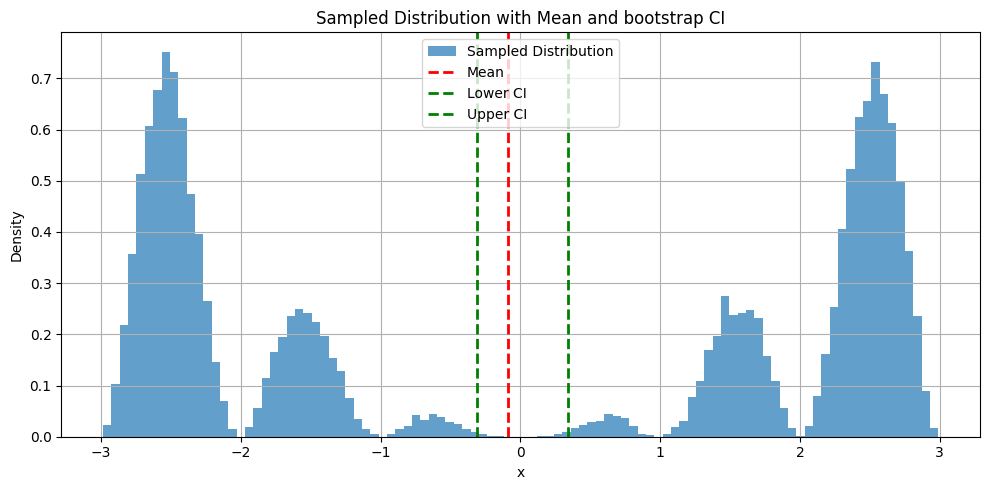

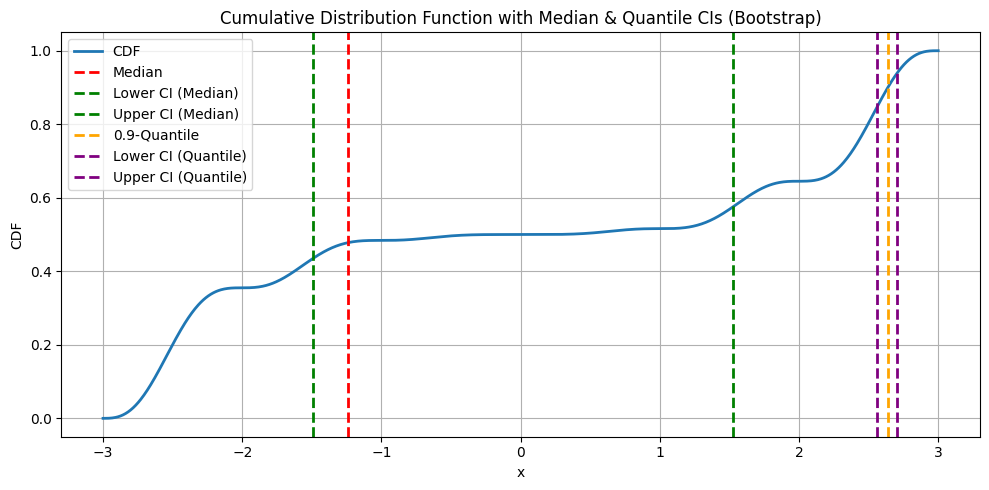

In [8]:
# Computing confidence intervals with bootstrap procedure

for i in range(1000):
    # Generate bootstrap samples
    boot_sample = np.random.choice(sample, size=num_subsamples, replace=True)
    b_median = np.median(boot_sample)
    b_quantile = np.quantile(boot_sample, q)
    b_mean = np.mean(boot_sample)


    if i == 0:
        medians = np.array([b_median])
        quantiles = np.array([b_quantile])
        means = np.array([b_mean])

    else:
        medians = np.append(medians, b_median)
        quantiles = np.append(quantiles, b_quantile)
        means = np.append(means, b_mean)

# Sort
medians = list(np.sort(medians))
quantiles = list(np.sort(quantiles))
means = list(np.sort(means))

# Compute the confidence intervals

med_l_CI_boot = medians[25]
med_u_CI_boot = medians[975]

q_l_CI_boot = quantiles[25]
q_u_CI_boot = quantiles[975]

mean_l_CI_boot = means[25]
mean_u_CI_boot = means[975]

print("Median:", median)
print("Confidence Interval:", (float(med_l_CI_boot), float(med_u_CI_boot)))
print("Confidence Interval width:", float(med_u_CI_boot) - float(med_l_CI_boot))
print("=================================================================")
print("0.9 Quantile:", quantile)
print("Confidence Interval:", (float(q_l_CI_boot), float(q_u_CI_boot)))
print("Confidence Interval width:", float(q_u_CI_boot) - float(q_l_CI_boot))
print("=================================================================")
print("Mean:", sample_mean)
print("Confidence Interval:", (float(mean_l_CI_boot), float(mean_u_CI_boot)))
print("Confidence Interval width:", float(mean_u_CI_boot) - float(mean_l_CI_boot))


plt.figure(figsize=(10, 5))
plt.hist(sample, bins=100, density=True, alpha=0.7, label='Sampled Distribution')
plt.axvline(sample_mean, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(mean_l_CI_boot, color='green', linestyle='dashed', linewidth=2, label='Lower CI')
plt.axvline(mean_u_CI_boot, color='green', linestyle='dashed', linewidth=2, label='Upper CI')
plt.title("Sampled Distribution with Mean and bootstrap CI")
plt.xlabel("x")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(x_points, cdf, linewidth=2, label="CDF")

# Add median and its confidence intervals.
plt.axvline(median, color='red', linestyle='dashed', linewidth=2, label='Median')
plt.axvline(med_l_CI_boot, color='green', linestyle='dashed', linewidth=2, label='Lower CI (Median)')
plt.axvline(med_u_CI_boot, color='green', linestyle='dashed', linewidth=2, label='Upper CI (Median)')

# Add quantile and its confidence intervals.
plt.axvline(quantile, color='orange', linestyle='dashed', linewidth=2, label=f'{q}-Quantile')
plt.axvline(q_l_CI_boot, color='purple', linestyle='dashed', linewidth=2, label='Lower CI (Quantile)')
plt.axvline(q_u_CI_boot, color='purple', linestyle='dashed', linewidth=2, label='Upper CI (Quantile)')

plt.title("Cumulative Distribution Function with Median & Quantile CIs (Bootstrap)")
plt.xlabel("x")
plt.ylabel("CDF")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Number of confidence intervals (computed with normal approximation) that contain the true mean 0: 96
Number of confidence intervals (computed with bootstrap) that contain the true mean 0: 95


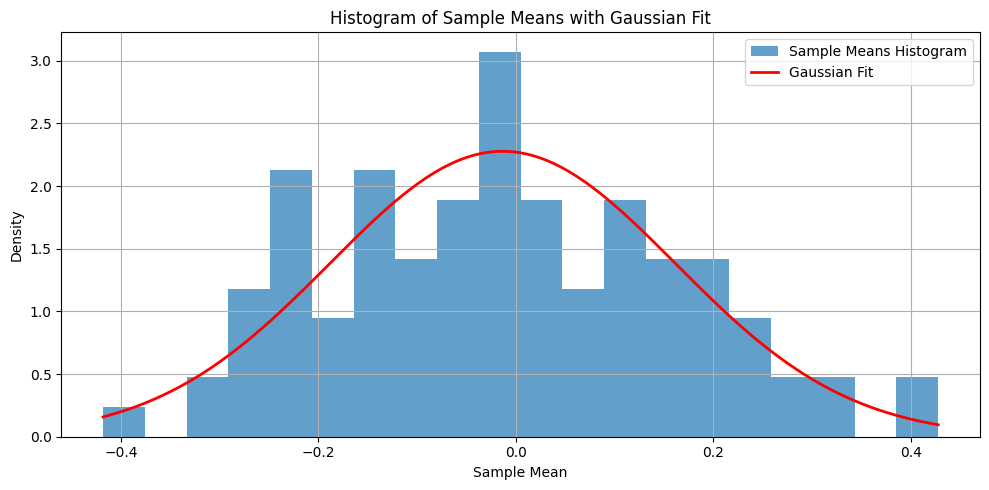

In [9]:

num_samples = 20000
sample = sample_valid(n_valid=num_samples, batch_size=1000)
n_sub = 200
num_bootstrap = 1000 #number of bootstrap repetitions
CI_contains_bootstrap = 0
CI_contains = 0

sm_array = np.empty(100)

for i in range(100):
    subset = sample[i * n_sub:(i + 1) * n_sub]
    bootstrap_means = np.empty(num_bootstrap)

    for j in range(num_bootstrap):
        boot_sample = np.random.choice(subset, size=n_sub, replace=True)
        bootstrap_means[j] = np.mean(boot_sample)
    
    boot_l_CI_mean = np.percentile(bootstrap_means, 2.5)
    boot_u_CI_mean = np.percentile(bootstrap_means, 97.5)
    
    sample_std_dev = np.std(subset, ddof=1)  # Sample standard deviation with Bessel's correction
    sample_mean = np.mean(subset)  
    sm_array[i]= sample_mean
    l_CI_mean = sample_mean - 1.96*sample_std_dev/math.sqrt(len(subset))
    u_CI_mean = sample_mean + 1.96*sample_std_dev/math.sqrt(len(subset))
   

    if l_CI_mean <= 0 <= u_CI_mean:
        CI_contains += 1
    if boot_l_CI_mean <= 0 <= boot_u_CI_mean:
        CI_contains_bootstrap += 1


print("Number of confidence intervals (computed with normal approximation) that contain the true mean 0:", CI_contains)
print("Number of confidence intervals (computed with bootstrap) that contain the true mean 0:", CI_contains_bootstrap)

# Plotting the histogram of sample means
mean_sm = np.mean(sm_array)
std_sm = np.std(sm_array, ddof=1)
x_fit = np.linspace(sm_array.min(), sm_array.max(), 200)
pdf_fit = 1/(std_sm * np.sqrt(2*np.pi)) * np.exp(-0.5 * ((x_fit - mean_sm)/std_sm)**2)

plt.figure(figsize=(10, 5))
plt.hist(sm_array, bins=20,density=True, alpha=0.7, label='Sample Means Histogram')
plt.plot(x_fit, pdf_fit, color='red', linewidth=2, label='Gaussian Fit')
plt.title("Histogram of Sample Means with Gaussian Fit")
plt.xlabel("Sample Mean")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()